# **Detección de anomalías en los patrones de comportamiento de los clientes no regulados en la filial Electro Dunas del Grupo Energía Bogotá**

Este Notebook, hace parte del trabajo de grado de la maestría en inteligencia analítica de datos de la Universidad de los Andes en él se realizan gráficas para contextualizar la identificación de anomalías por medio de los modelos Isolation Forest, Robust Covariance, Local Outlier Factor (LOF),  energía eléctrica de distintos clientes de Electrodunas.  

Realizado por: Miller Puentes, Grace González, Camilo, Robayo, Joan Chacón.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import warnings
from datetime import datetime
from ipywidgets import widgets, interact
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [ ]:
# Para colocar el enlace al Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lista todos los archivos csv en la carpeta de gerencia
folder_path = '/content/drive/My Drive/MIAD/gerencia/'
files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Crea un DataFrame vacío para almacenar todos los datos
all_data = pd.DataFrame()

# Itera sobre los archivos y los concatena en el DataFrame all_data
for file in files:
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path)

    # Extrae el número de cliente del nombre del archivo (suponiendo que es el número que viene después de 'CLIENTE' y antes del '.csv')
    cliente_id = int(file.replace('DATOSCLIENTE', '').replace('.csv', ''))

    # Agrega la columna cliente_id al DataFrame
    data['Cliente_ID'] = cliente_id

    all_data = pd.concat([all_data, data], ignore_index=True)



# Asegúrate de cambiar el nombre del archivo y la ruta si es necesario
file_path = '/content/drive/My Drive/MIAD/gerencia/sector_economico_clientes.xlsx'
sector_economico_clientes = pd.read_excel(file_path)

# Muestra las primeras filas del dataframe


sector_economico_clientes['Cliente_ID'] = (
    sector_economico_clientes['Cliente:']
    .str.extract('(\d+)')  # Extrae el número del nombre del cliente
    .astype(int)           # Convierte el resultado en entero
)

data_merged = pd.merge(all_data, sector_economico_clientes, on='Cliente_ID', how='left')

# Muestra las primeras filas del dataframe combinado
data_merged.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Cliente:,Sector Económico:
0,2021-01-01 00:00:00,2.835149,3.444510,1177.027645,1088.563280,12,Cliente 12,Cultivo de otros frutos y nueces de árboles y ...
1,2021-01-01 01:00:00,3.107207,3.031774,1159.764890,1304.578388,12,Cliente 12,Cultivo de otros frutos y nueces de árboles y ...
2,2021-01-01 02:00:00,2.720585,3.108985,1141.648393,1028.819502,12,Cliente 12,Cultivo de otros frutos y nueces de árboles y ...
3,2021-01-01 03:00:00,2.680349,3.138547,1019.959871,1140.120080,12,Cliente 12,Cultivo de otros frutos y nueces de árboles y ...
4,2021-01-01 04:00:00,2.478501,3.360516,1098.094481,1092.700887,12,Cliente 12,Cultivo de otros frutos y nueces de árboles y ...


In [ ]:
data_filtered_neg = data_merged[data_merged['Active_energy'] >= 0]
print(data_merged.shape)
print(data_filtered_neg.shape)


data_filtered_neg_sorted=data_filtered_neg.sort_values(by=['Cliente_ID', 'Fecha'])

data_filtered_neg_sorted['Fecha'] = pd.to_datetime(data_filtered_neg_sorted['Fecha'])

# Asegurarse de que solo se incluyan las fechas deseadas
data_filtered_neg_sorted = data_filtered_neg_sorted[(data_filtered_neg_sorted['Fecha'].dt.year >= 2020) & (data_filtered_neg_sorted['Fecha'].dt.year <= 2024)]

(463425, 8)
(462920, 8)


In [ ]:
def detect_anomalies_iforest(client_id, data, n_estimators=200, contamination_rate=0.05):

    client_data = data[data['Cliente_ID'] == client_id].copy()

    # Solo energía activa
    client_data['Active_energy'] = client_data['Active_energy'].astype(np.float64)

    # Isolation Forest
    iforest = IsolationForest(n_estimators=n_estimators, contamination=contamination_rate, random_state=123)
    # Fit
    anomalies = iforest.fit_predict(client_data[['Active_energy']])
    # Convertir anomalias labels  -1/1 to 0/1 (0 for normal, 1 for anomaly)
    client_data['Anomaly_IF'] = (anomalies == -1).astype(int)
    client_data['Anomaly_Score_IF'] = iforest.decision_function(client_data[['Active_energy']])


    client_data['Fecha'] = pd.to_datetime(client_data['Fecha'])
    client_data['Month'] = client_data['Fecha'].dt.month
    client_data['Day_of_Week'] = client_data['Fecha'].dt.dayofweek

    return client_data

# Using the correct DataFrame, assuming 'data_filtered_neg_sorted'
unique_clients = data_filtered_neg_sorted['Cliente_ID'].unique()
all_results = []

for client_id in unique_clients:
    client_results = detect_anomalies_iforest(client_id, data_filtered_neg_sorted)
    all_results.append(client_results)

# Concatenar
final_df = pd.concat(all_results)

final_df = final_df[['Fecha', 'Cliente_ID', 'Sector Económico:', 'Day_of_Week', 'Month', 'Anomaly_IF', 'Anomaly_Score_IF']]

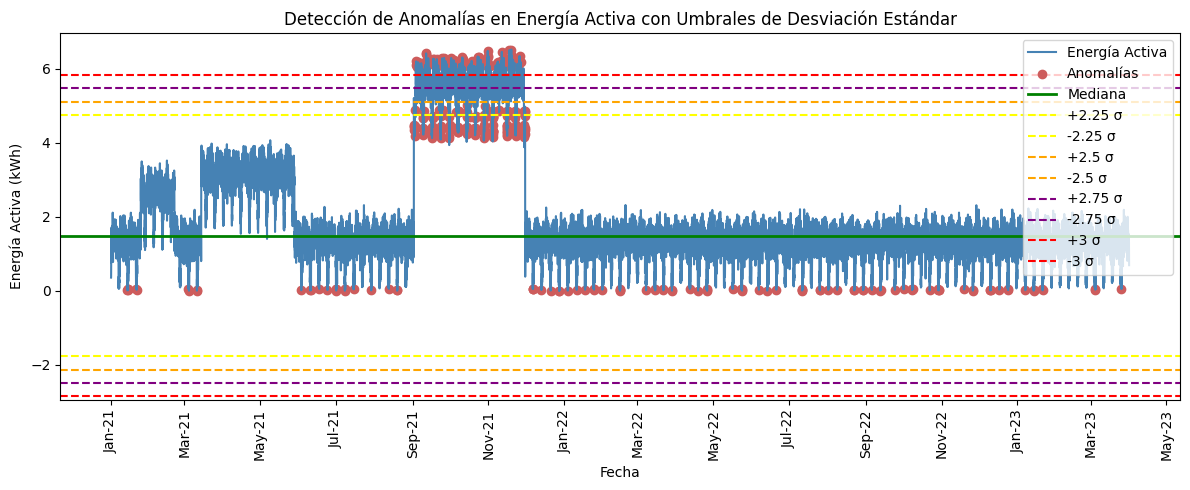

In [ ]:
def detect_anomalies_iforest(client_id, data, n_estimators=100, contamination_rate=0.02):
    client_data = data[data['Cliente_ID'] == client_id].copy()
    iforest = IsolationForest(n_estimators=n_estimators, contamination=contamination_rate, random_state=123)

    # Asegúrate de que la energía activa esté en formato numérico
    client_data['Active_energy'] = client_data['Active_energy'].astype(np.float64)

    # Entrena el modelo y predice las anomalías
    client_data['Anomaly'] = iforest.fit_predict(client_data[['Active_energy']])
    client_data['Anomaly_Score'] = iforest.decision_function(client_data[['Active_energy']])

    # Calcula la mediana de la energía activa y la añade como una columna constante
    client_data['Median'] = client_data['Active_energy'].median()
    return client_data

def plot_anomalies_with_thresholds(client_data):
    # Extrae la mediana y la desviación estándar de la energía activa
    median_energy = client_data['Median'].iloc[0]
    std_energy = client_data['Active_energy'].std()

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(client_data['Fecha'], client_data['Active_energy'], label='Energía Activa', color='steelblue')
    anomalies = client_data[client_data['Anomaly'] == -1]

    # Marca las anomalías en el gráfico
    ax.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='indianred', label='Anomalías')

    # Dibuja la línea de la mediana
    ax.axhline(median_energy, color='green', linestyle='-', linewidth=2, label='Mediana')

    # Dibuja líneas horizontales para la mediana +/- múltiplos de la desviación estándar
    deviations = [2.25, 2.5, 2.75, 3]
    colors = ['yellow', 'orange', 'purple', 'red']
    for deviation, color in zip(deviations, colors):
        ax.axhline(median_energy + deviation * std_energy, color=color, linestyle='--', label=f'+{deviation} σ')
        ax.axhline(median_energy - deviation * std_energy, color=color, linestyle='--', label=f'-{deviation} σ')

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    plt.xticks(rotation=90)

    ax.set_title('Detección de Anomalías en Energía Activa con Umbrales de Desviación Estándar')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Energía Activa (kWh)')

    # Configura la leyenda para que se muestre en la esquina superior derecha
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# Supongamos que 'data_filtered_neg_sorted' es tu DataFrame con datos filtrados y ordenados
client_id = 1  # Asegúrate de que este ID esté en tus datos
client_data = detect_anomalies_iforest(client_id, data_filtered_neg_sorted)
plot_anomalies_with_thresholds(client_data)


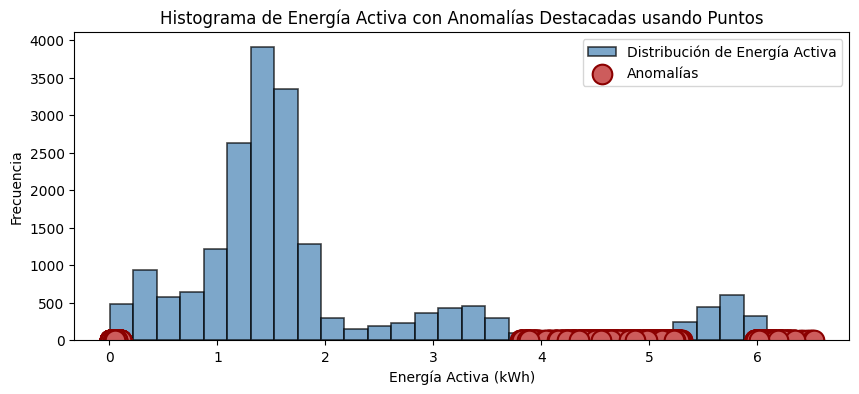

In [ ]:
def plot_anomalies_on_histogram(client_data):
    # Prepara los datos
    energy_data = client_data['Active_energy']
    anomalies = client_data[client_data['Anomaly'] == -1]['Active_energy']

    # Crea el histograma de la energía activa
    plt.figure(figsize=(10, 4))
    plt.hist(energy_data, bins=30, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.2, label='Distribución de Energía Activa')

    # Resalta las anomalías con un scatter plot
    plt.scatter(anomalies, [0]*len(anomalies), color='indianred', s=200, edgecolor='darkred', linewidth=1.5, label='Anomalías', zorder=2)

    # Agrega etiquetas y título
    plt.xlabel('Energía Activa (kWh)')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de Energía Activa con Anomalías Destacadas usando Puntos')
    plt.legend()

    # Muestra el gráfico
    plt.show()

# Asumiendo que 'client_data' ya contiene las anomalías detectadas por Robust Covariance
plot_anomalies_on_histogram(client_data)


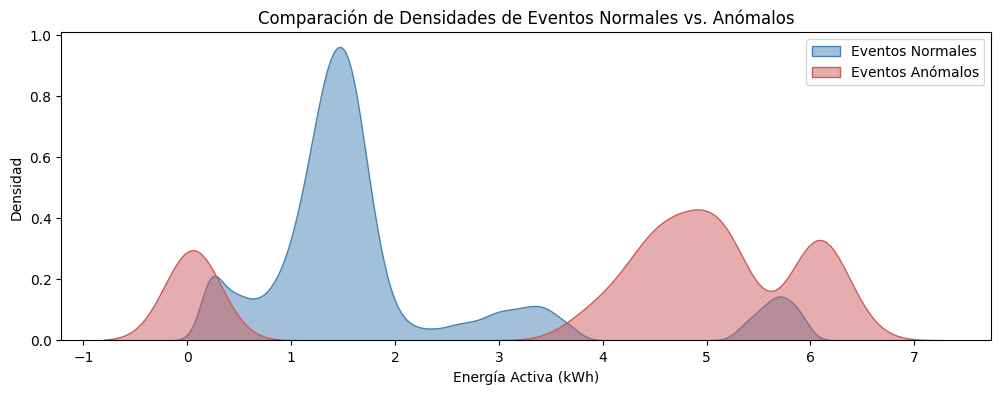

In [ ]:
def plot_density_comparison(client_data):
    # Separa los datos en normales y anómalos
    normal_data = client_data[client_data['Anomaly'] == 1]['Active_energy']
    anomaly_data = client_data[client_data['Anomaly'] == -1]['Active_energy']

    # Configura el gráfico
    plt.figure(figsize=(12, 4))
    sns.kdeplot(normal_data, color='steelblue', label='Eventos Normales', fill=True, alpha=0.5, bw_adjust=0.5)
    sns.kdeplot(anomaly_data, color='indianred', label='Eventos Anómalos', fill=True, alpha=0.5, bw_adjust=0.5)

    # Añade títulos y etiquetas
    plt.title('Comparación de Densidades de Eventos Normales vs. Anómalos')
    plt.xlabel('Energía Activa (kWh)')
    plt.ylabel('Densidad')
    plt.legend()

    # Muestra el gráfico
    plt.show()

# Suponiendo que 'client_data' ya contiene las anomalías detectadas por Isolation Forest
plot_density_comparison(client_data)


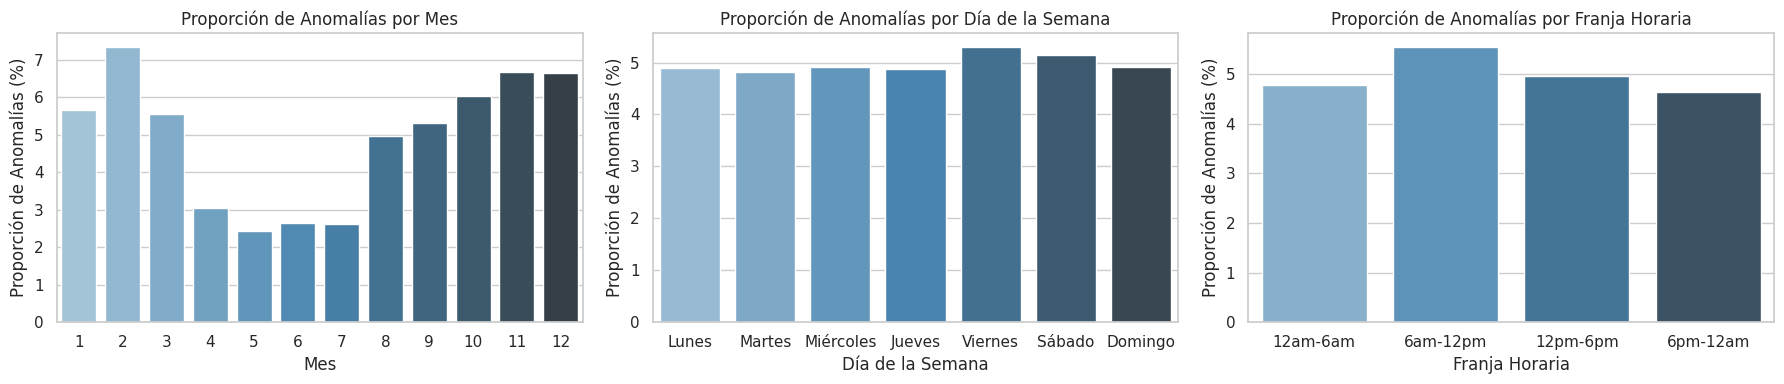

In [ ]:
def prepare_data(data):
    # Mapeo de números a nombres de días de la semana
    day_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
    data['DayName'] = data['DayOfWeek'].map(day_map)

    # Convertir 'DayName' a una categoría con orden específico
    categories = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    data['DayName'] = pd.Categorical(data['DayName'], categories=categories, ordered=True)

    return data

def calculate_proportions(data):
    categories = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    monthly = data.groupby('Month')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)
    weekly = data.groupby('DayName')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100).reindex(categories)
    hourly = data.groupby('TimeOfDay')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)

    return monthly, weekly, hourly


def plot_proportions(monthly, weekly, hourly):
    categories = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)

    sns.barplot(x=monthly.index, y=monthly.values, palette='Blues_d', ax=axes[0])
    axes[0].set_title('Proporción de Anomalías por Mes')
    axes[0].set_xlabel('Mes')
    axes[0].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=weekly.index, y=weekly.values, palette='Blues_d', ax=axes[1], order=categories)
    axes[1].set_title('Proporción de Anomalías por Día de la Semana')
    axes[1].set_xlabel('Día de la Semana')
    axes[1].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=hourly.index, y=hourly.values, palette='Blues_d', ax=axes[2])
    axes[2].set_title('Proporción de Anomalías por Franja Horaria')
    axes[2].set_xlabel('Franja Horaria')
    axes[2].set_ylabel('Proporción de Anomalías (%)')

    plt.show()



# Supongamos que 'data' es tu DataFrame con todos los datos
# Asegúrate de que 'Fecha' y 'Active_energy' están en tu DataFrame
data = data_filtered_neg_sorted
data = detect_anomalies_for_all(data)
monthly, weekly, hourly = calculate_proportions(data)
plot_proportions(monthly, weekly, hourly)


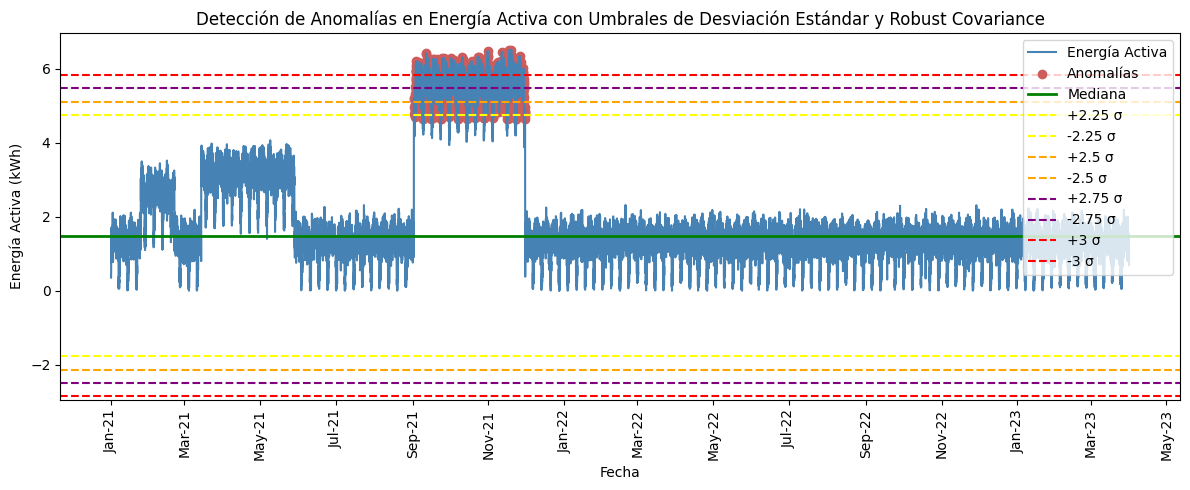

In [ ]:
def detect_anomalies_robust_covariance(client_id, data, contamination_rate=0.1):
    client_data = data[data['Cliente_ID'] == client_id].copy()

    # Asegúrate de que la energía activa esté en formato numérico
    client_data['Active_energy'] = client_data['Active_energy'].astype(np.float64)

    # Inicializa y entrena el modelo Robust Covariance
    robust_cov = EllipticEnvelope(contamination=contamination_rate, random_state=123)
    client_data['Anomaly'] = robust_cov.fit_predict(client_data[['Active_energy']])
    client_data['Anomaly_Score'] = robust_cov.decision_function(client_data[['Active_energy']])

    # Calcula la mediana de la energía activa y la añade como una columna constante
    client_data['Median'] = client_data['Active_energy'].median()
    return client_data

def plot_anomalies_with_thresholds(client_data):
    # Extrae la mediana y la desviación estándar de la energía activa
    median_energy = client_data['Median'].iloc[0]
    std_energy = client_data['Active_energy'].std()

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(client_data['Fecha'], client_data['Active_energy'], label='Energía Activa', color='steelblue')
    anomalies = client_data[client_data['Anomaly'] == -1]

    # Marca las anomalías en el gráfico
    ax.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='indianred', label='Anomalías')

    # Dibuja la línea de la mediana
    ax.axhline(median_energy, color='green', linestyle='-', linewidth=2, label='Mediana')

    # Dibuja líneas horizontales para la mediana +/- múltiplos de la desviación estándar
    deviations = [2.25, 2.5, 2.75, 3]
    colors = ['yellow', 'orange', 'purple', 'red']
    for deviation, color in zip(deviations, colors):
        ax.axhline(median_energy + deviation * std_energy, color=color, linestyle='--', label=f'+{deviation} σ')
        ax.axhline(median_energy - deviation * std_energy, color=color, linestyle='--', label=f'-{deviation} σ')

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    plt.xticks(rotation=90)

    ax.set_title('Detección de Anomalías en Energía Activa con Umbrales de Desviación Estándar y Robust Covariance')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Energía Activa (kWh)')

    # Configura la leyenda para que se muestre en la esquina superior derecha
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Supongamos que 'data_filtered_neg_sorted' es tu DataFrame con datos filtrados y ordenados
client_id = 1  # Asegúrate de que este ID esté en tus datos
client_data = detect_anomalies_robust_covariance(client_id, data_filtered_neg_sorted)
plot_anomalies_with_thresholds(client_data)


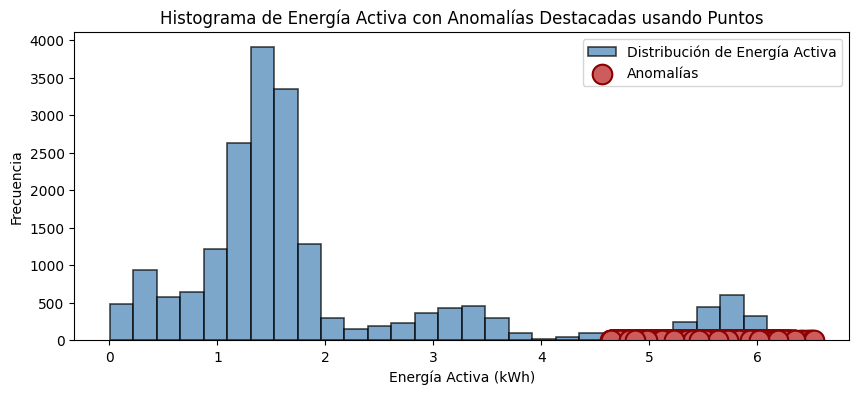

In [ ]:
def plot_anomalies_on_histogram(client_data):
    # Prepara los datos
    energy_data = client_data['Active_energy']
    anomalies = client_data[client_data['Anomaly'] == -1]['Active_energy']

    # Crea el histograma de la energía activa
    plt.figure(figsize=(10, 4))
    plt.hist(energy_data, bins=30, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.2, label='Distribución de Energía Activa')

    # Resalta las anomalías con un scatter plot
    plt.scatter(anomalies, [0]*len(anomalies), color='indianred', s=200, edgecolor='darkred', linewidth=1.5, label='Anomalías', zorder=2)

    # Agrega etiquetas y título
    plt.xlabel('Energía Activa (kWh)')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de Energía Activa con Anomalías Destacadas usando Puntos')
    plt.legend()

    # Muestra el gráfico
    plt.show()

# Asumiendo que 'client_data' ya contiene las anomalías detectadas por Robust Covariance
plot_anomalies_on_histogram(client_data)


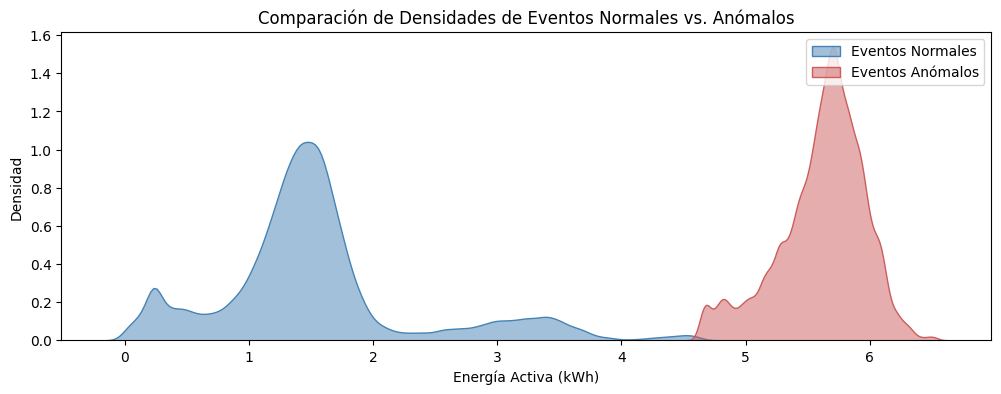

In [ ]:
def plot_density_comparison(client_data):
    # Separa los datos en normales y anómalos
    normal_data = client_data[client_data['Anomaly'] == 1]['Active_energy']
    anomaly_data = client_data[client_data['Anomaly'] == -1]['Active_energy']

    # Configura el gráfico
    plt.figure(figsize=(12, 4))
    sns.kdeplot(normal_data, color='steelblue', label='Eventos Normales', fill=True, alpha=0.5, bw_adjust=0.5)
    sns.kdeplot(anomaly_data, color='indianred', label='Eventos Anómalos', fill=True, alpha=0.5, bw_adjust=0.5)

    # Añade títulos y etiquetas
    plt.title('Comparación de Densidades de Eventos Normales vs. Anómalos')
    plt.xlabel('Energía Activa (kWh)')
    plt.ylabel('Densidad')
    plt.legend()

    # Muestra el gráfico
    plt.show()

# Suponiendo que 'client_data' ya contiene las anomalías detectadas por Isolation Forest
plot_density_comparison(client_data)


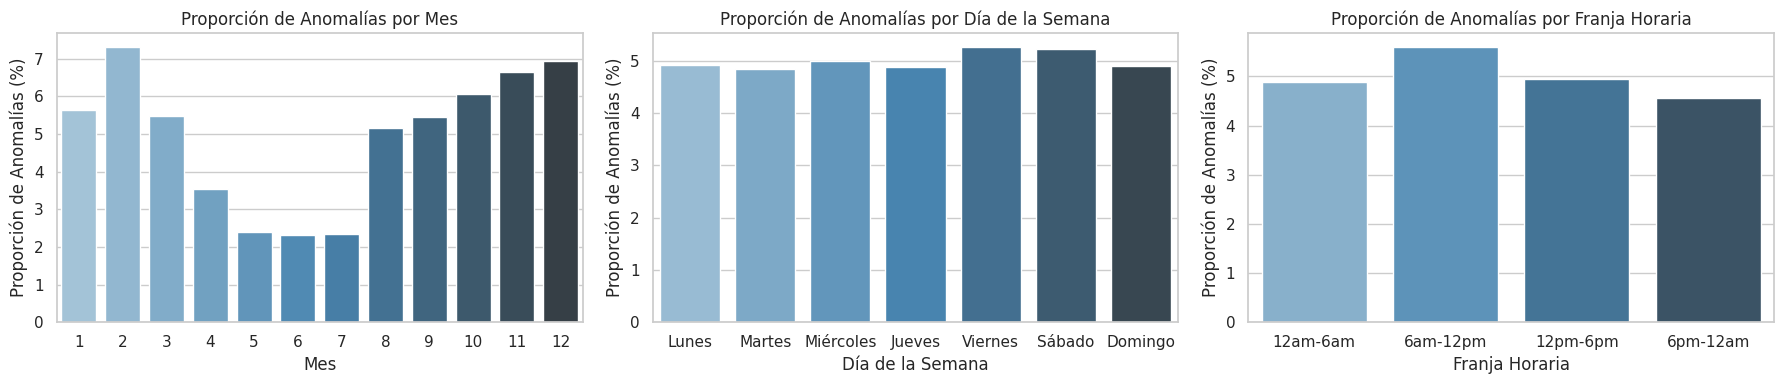

In [ ]:

# Mapeo de números a nombres de días de la semana
day_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

def detect_anomalies_for_all(data, contamination_rate=0.05):
    # Convertir a formato numérico
    data['Active_energy'] = data['Active_energy'].astype(np.float64)

    # Inicializa y entrena el modelo Elliptic Envelope
    robust_cov = EllipticEnvelope(contamination=contamination_rate, random_state=123)
    robust_cov.fit(data[['Active_energy']])
    data['Anomaly'] = robust_cov.predict(data[['Active_energy']])

    # Agregar información temporal
    data['Month'] = pd.to_datetime(data['Fecha']).dt.month
    data['DayOfWeek'] = pd.to_datetime(data['Fecha']).dt.dayofweek
    data['DayName'] = data['DayOfWeek'].map(day_map)
    data['DayName'] = pd.Categorical(data['DayName'], categories=day_order, ordered=True)
    data['Hour'] = pd.to_datetime(data['Fecha']).dt.hour

    return data

def calculate_proportions(data):
    # Calcula la proporción de anomalías por mes
    monthly = data.groupby('Month')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)

    # Calcula la proporción de anomalías por día de la semana
    weekly = data.groupby('DayName')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)

    # Calcula la proporción de anomalías por franja horaria
    bins = [0, 6, 12, 18, 24]
    labels = ['12am-6am', '6am-12pm', '12pm-6pm', '6pm-12am']
    data['TimeOfDay'] = pd.cut(data['Hour'], bins=bins, labels=labels, right=False)
    hourly = data.groupby('TimeOfDay')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)

    return monthly, weekly, hourly

def plot_proportions(monthly, weekly, hourly):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    sns.barplot(x=monthly.index, y=monthly.values, palette='Blues_d', ax=axes[0])
    axes[0].set_title('Proporción de Anomalías por Mes')
    axes[0].set_xlabel('Mes')
    axes[0].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=weekly.index, y=weekly.values, palette='Blues_d', ax=axes[1], order=day_order)
    axes[1].set_title('Proporción de Anomalías por Día de la Semana')
    axes[1].set_xlabel('Día de la Semana')
    axes[1].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=hourly.index, y=hourly.values, palette='Blues_d', ax=axes[2])
    axes[2].set_title('Proporción de Anomalías por Franja Horaria')
    axes[2].set_xlabel('Franja Horaria')
    axes[2].set_ylabel('Proporción de Anomalías (%)')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso del código
# Supongamos que 'data' es tu DataFrame con todos los datos cargados apropiadamente
data = data_filtered_neg_sorted
data = detect_anomalies_for_all(data)
monthly, weekly, hourly = calculate_proportions(data)
plot_proportions(monthly, weekly, hourly)

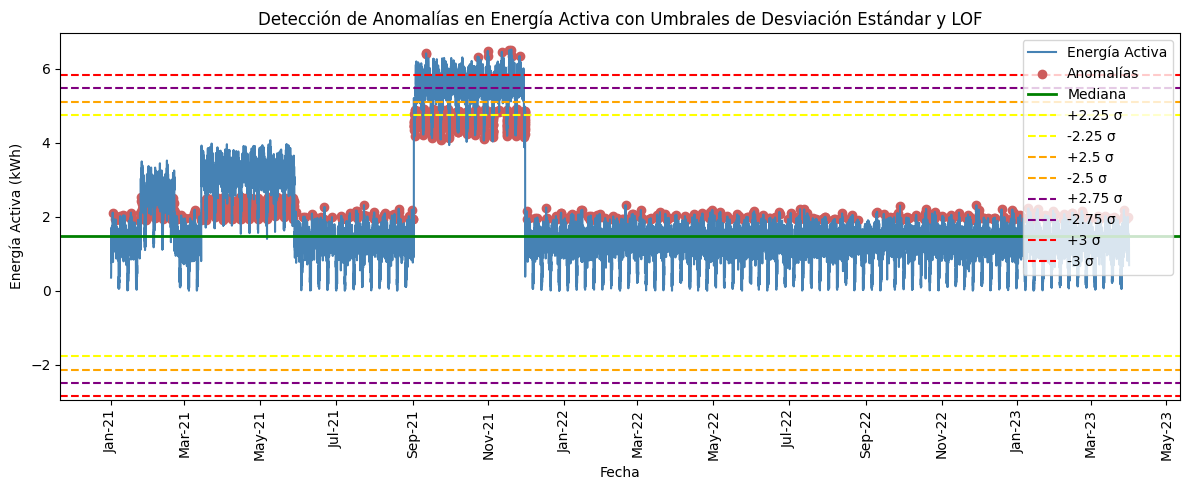

In [ ]:
def detect_anomalies_lof(client_id, data, n_neighbors=1500, contamination_rate=0.05):
    client_data = data[data['Cliente_ID'] == client_id].copy()

    # Asegúrate de que la energía activa esté en formato numérico
    client_data['Active_energy'] = client_data['Active_energy'].astype(np.float64)

    # Inicializa y entrena el modelo LOF
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination_rate, novelty=True)
    lof.fit(client_data[['Active_energy']])  # Entrenamiento para encontrar los factores de outlier

    # Detecta las anomalías como nuevas observaciones (novelty detection)
    client_data['Anomaly'] = lof.predict(client_data[['Active_energy']])
    client_data['Anomaly_Score'] = lof.decision_function(client_data[['Active_energy']])

    # Calcula la mediana de la energía activa y la añade como una columna constante
    client_data['Median'] = client_data['Active_energy'].median()
    return client_data

def plot_anomalies_with_thresholds(client_data):
    # Extrae la mediana y la desviación estándar de la energía activa
    median_energy = client_data['Median'].iloc[0]
    std_energy = client_data['Active_energy'].std()

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(client_data['Fecha'], client_data['Active_energy'], label='Energía Activa', color='steelblue')
    anomalies = client_data[client_data['Anomaly'] == -1]

    # Marca las anomalías en el gráfico
    ax.scatter(anomalies['Fecha'], anomalies['Active_energy'], color='indianred', label='Anomalías')

    # Dibuja la línea de la mediana
    ax.axhline(median_energy, color='green', linestyle='-', linewidth=2, label='Mediana')

    # Dibuja líneas horizontales para la mediana +/- múltiplos de la desviación estándar
    deviations = [2.25, 2.5, 2.75, 3]
    colors = ['yellow', 'orange', 'purple', 'red']
    for deviation, color in zip(deviations, colors):
        ax.axhline(median_energy + deviation * std_energy, color=color, linestyle='--', label=f'+{deviation} σ')
        ax.axhline(median_energy - deviation * std_energy, color=color, linestyle='--', label=f'-{deviation} σ')

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    plt.xticks(rotation=90)

    ax.set_title('Detección de Anomalías en Energía Activa con Umbrales de Desviación Estándar y LOF')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Energía Activa (kWh)')

    # Configura la leyenda para que se muestre en la esquina superior derecha
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Supongamos que 'data_filtered_neg_sorted' es tu DataFrame con datos filtrados y ordenados
client_id = 1  # Asegúrate de que este ID esté en tus datos
client_data = detect_anomalies_lof(client_id, data_filtered_neg_sorted)
plot_anomalies_with_thresholds(client_data)


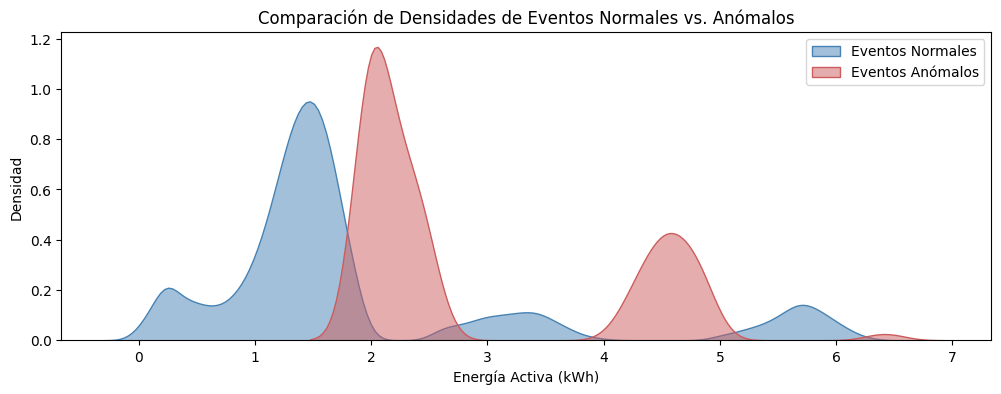

In [ ]:
def plot_density_comparison(client_data):
    # Separa los datos en normales y anómalos
    normal_data = client_data[client_data['Anomaly'] == 1]['Active_energy']
    anomaly_data = client_data[client_data['Anomaly'] == -1]['Active_energy']

    # Configura el gráfico
    plt.figure(figsize=(12, 4))
    sns.kdeplot(normal_data, color='steelblue', label='Eventos Normales', fill=True, alpha=0.5, bw_adjust=0.5)
    sns.kdeplot(anomaly_data, color='indianred', label='Eventos Anómalos', fill=True, alpha=0.5, bw_adjust=0.5)

    # Añade títulos y etiquetas
    plt.title('Comparación de Densidades de Eventos Normales vs. Anómalos')
    plt.xlabel('Energía Activa (kWh)')
    plt.ylabel('Densidad')
    plt.legend()

    # Muestra el gráfico
    plt.show()

# Suponiendo que 'client_data' ya contiene las anomalías detectadas por Isolation Forest
plot_density_comparison(client_data)


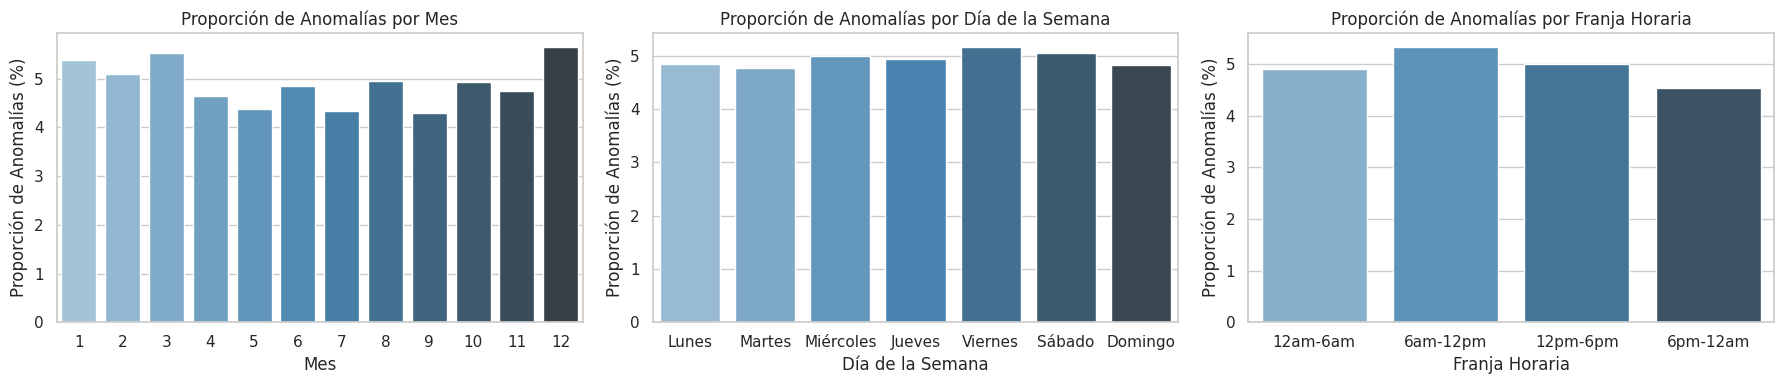

In [ ]:
# Mapeo de números a nombres de días de la semana
day_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

def detect_anomalies_for_all(data, n_neighbors=450, contamination_rate=0.05):
    # Convertir a formato numérico
    data['Active_energy'] = data['Active_energy'].astype(np.float64)

    # Inicializa y entrena el modelo LOF
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination_rate, novelty=True)
    lof.fit(data[['Active_energy']])
    data['Anomaly'] = lof.predict(data[['Active_energy']])

    # Agregar información temporal
    data['Month'] = pd.to_datetime(data['Fecha']).dt.month
    data['DayOfWeek'] = pd.to_datetime(data['Fecha']).dt.dayofweek
    data['DayName'] = data['DayOfWeek'].map(day_map)
    data['DayName'] = pd.Categorical(data['DayName'], categories=day_order, ordered=True)
    data['Hour'] = pd.to_datetime(data['Fecha']).dt.hour

    return data

def calculate_proportions(data):
    # Calcula la proporción de anomalías por mes
    monthly = data.groupby('Month')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)

    # Calcula la proporción de anomalías por día de la semana
    weekly = data.groupby('DayName')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)

    # Calcula la proporción de anomalías por franja horaria
    bins = [0, 6, 12, 18, 24]
    labels = ['12am-6am', '6am-12pm', '12pm-6pm', '6pm-12am']
    data['TimeOfDay'] = pd.cut(data['Hour'], bins=bins, labels=labels, right=False)
    hourly = data.groupby('TimeOfDay')['Anomaly'].apply(lambda x: (x == -1).sum() / len(x) * 100)

    return monthly, weekly, hourly

def plot_proportions(monthly, weekly, hourly):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    sns.barplot(x=monthly.index, y=monthly.values, palette='Blues_d', ax=axes[0])
    axes[0].set_title('Proporción de Anomalías por Mes')
    axes[0].set_xlabel('Mes')
    axes[0].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=weekly.index, y=weekly.values, palette='Blues_d', ax=axes[1], order=day_order)
    axes[1].set_title('Proporción de Anomalías por Día de la Semana')
    axes[1].set_xlabel('Día de la Semana')
    axes[1].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=hourly.index, y=hourly.values, palette='Blues_d', ax=axes[2])
    axes[2].set_title('Proporción de Anomalías por Franja Horaria')
    axes[2].set_xlabel('Franja Horaria')
    axes[2].set_ylabel('Proporción de Anomalías (%)')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso del código
# Supongamos que 'data' es tu DataFrame con todos los datos cargados apropiadamente
#
data = data_filtered_neg_sorted
data = detect_anomalies_for_all(data)
monthly, weekly, hourly = calculate_proportions(data)
plot_proportions(monthly, weekly, hourly)


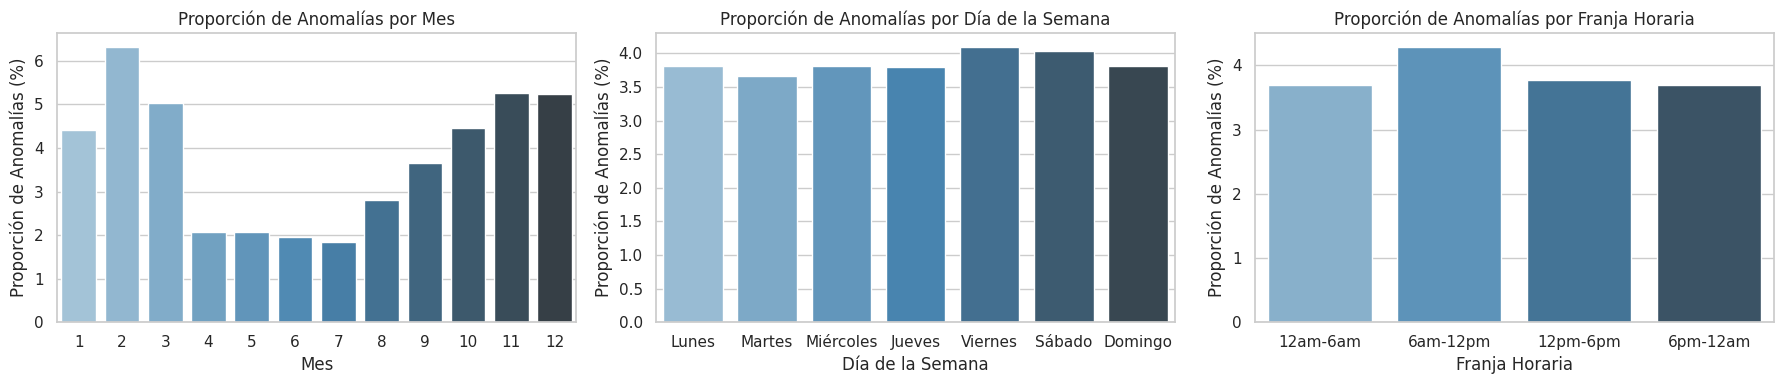

In [ ]:
day_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

def detect_anomalies_z_score(data, threshold=2.5):
    data['Active_energy'] = data['Active_energy'].astype(np.float64)
    mean = data['Active_energy'].mean()
    std_dev = data['Active_energy'].std()

    # Definir límites para detectar anomalías
    data['Anomaly'] = ((data['Active_energy'] < (mean - threshold * std_dev)) |
                       (data['Active_energy'] > (mean + threshold * std_dev))).astype(int)

    # Agregar información temporal
    data['Month'] = pd.to_datetime(data['Fecha']).dt.month
    data['DayOfWeek'] = pd.to_datetime(data['Fecha']).dt.dayofweek
    data['DayName'] = data['DayOfWeek'].map(day_map)
    data['DayName'] = pd.Categorical(data['DayName'], categories=day_order, ordered=True)
    data['Hour'] = pd.to_datetime(data['Fecha']).dt.hour

    return data

def calculate_proportions(data):
    monthly = data.groupby('Month')['Anomaly'].mean() * 100
    weekly = data.groupby('DayName')['Anomaly'].mean() * 100
    bins = [0, 6, 12, 18, 24]
    labels = ['12am-6am', '6am-12pm', '12pm-6pm', '6pm-12am']
    data['TimeOfDay'] = pd.cut(data['Hour'], bins=bins, labels=labels, right=False)
    hourly = data.groupby('TimeOfDay')['Anomaly'].mean() * 100

    return monthly, weekly, hourly

def plot_proportions(monthly, weekly, hourly):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    sns.barplot(x=monthly.index, y=monthly.values, palette='Blues_d', ax=axes[0])
    axes[0].set_title('Proporción de Anomalías por Mes')
    axes[0].set_xlabel('Mes')
    axes[0].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=weekly.index, y=weekly.values, palette='Blues_d', ax=axes[1], order=day_order)
    axes[1].set_title('Proporción de Anomalías por Día de la Semana')
    axes[1].set_xlabel('Día de la Semana')
    axes[1].set_ylabel('Proporción de Anomalías (%)')

    sns.barplot(x=hourly.index, y=hourly.values, palette='Blues_d', ax=axes[2])
    axes[2].set_title('Proporción de Anomalías por Franja Horaria')
    axes[2].set_xlabel('Franja Horaria')
    axes[2].set_ylabel('Proporción de Anomalías (%)')

    plt.tight_layout()
    plt.show()

# Supongamos que 'data' es tu DataFrame con todos los datos cargados apropiadamente
data = data_filtered_neg_sorted
data = detect_anomalies_z_score(data)
monthly, weekly, hourly = calculate_proportions(data)
plot_proportions(monthly, weekly, hourly)
